In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from tqdm import tqdm

In [4]:
from multicam.mah import get_mah

# Collect MAH data

In [5]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [6]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
ma = mah_data['ma']
am = mah_data['am']
# ma_peak = mah_data['ma_peak']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


# Construct indicators and merger ratio at each snapshot

In [7]:
# scale factor coarser bins 
min_scale, max_scale = np.min(scales), np.max(scales)
scale_bins = np.linspace(min_scale, max_scale, 20)
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])

In [8]:
# for each simulation scale, get MM 
# first we need merger ratio at every scale 
merger_ratio_inst  = np.zeros((len(cat), len(scales)))
merger_ratio_present = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices): 
        m2_name = f'm2_a{idx}' # TODO: Check what this corresponds to
        cpg_name = f'coprog_mvir_a{idx-1}' # want coprogenitor mass at previous timestep.
        mvir_name = f'mvir_a{idx}'
        
        # get inst ratios
        m2_ratio = cat[m2_name][i].item() / cat[mvir_name][i].item()
        merger_ratio_inst[i, j] = m2_ratio
        
        # present ratios
        m2_ratio = cat[m2_name][i] / cat['mvir'][i].item()
        merger_ratio_present[i, j] = m2_ratio
    

In [9]:
# construct indicator for each halo whether they have a MM in a given scale bine 
Mu = [0.3/1.3, 0.1 / 1.1 , 0.03 / (1 + 0.03), 0.01 / 1.01]
inst_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))
present_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))

# ignore all nanmax warning, these will return np.nan's which is expected. 
warnings.simplefilter("ignore", category=RuntimeWarning)

for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        # get largest merger ratio in this scale bin
        mask = (scales >= scale_bins[jj]) & (scales < scale_bins[jj+1])
        inst_mask[kk, :, jj] = np.nanmax(merger_ratio_inst[:, mask], axis=1) > mu
        present_mask[kk, :, jj] = np.nanmax(merger_ratio_present[:, mask], axis=1) > mu

# Training

In [10]:
from multicam.models import LinearRegression

## Train standard MultiCAM

In [23]:
x = ma

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

In [24]:
mc = LinearRegression(165, 5)
mc.fit(x,y)

In [25]:
# get mean cvir and mean predicted cvir for sanity check
cvir_mean = np.mean(cat['cvir'])
cvir_pred_mean = np.mean(mc.predict(x)[:,0])
np.abs(cvir_mean - cvir_pred_mean) / np.abs(cvir_mean) # very low error

6.324122566717943e-05

In [28]:
mc.predict(x)[4, 0], mc.predict(x[4, None, :])[0,0] # almost the same

(8.376669883728027, 8.38835620880127)

## MultiCAM with (coarse) merger ratios

In [15]:
# use coarser bins for merger bins like in the 'merger residuals' plots

x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

# use scale_bins instead of scales, take max over mergers in each bin.
x3 = np.zeros((x2.shape[0], scale_bins.shape[0]))
for ii, scale in enumerate(scales):
    jj = np.where(scale >= scale_bins)[0][-1]
    arr = np.vstack([x3[:, jj], x2[:, ii]])
    assert arr.shape == (2, 10000)
    x3[:, jj] = np.max(arr, axis=0)
    

In [16]:
x = np.concatenate([x1, x3], axis=1)

y = np.concatenate([cat['cvir'][:, None], cat['x0'][:, None], cat['t/|u|'][:, None], 
                    cat['spin_bullock'][:, None], cat['c_to_a'][:,None]], 
                    axis=1)

mc_merger2 = LinearRegression(185, 5)

In [17]:
mc_merger2.fit(x, y)

# Distributions don't match 

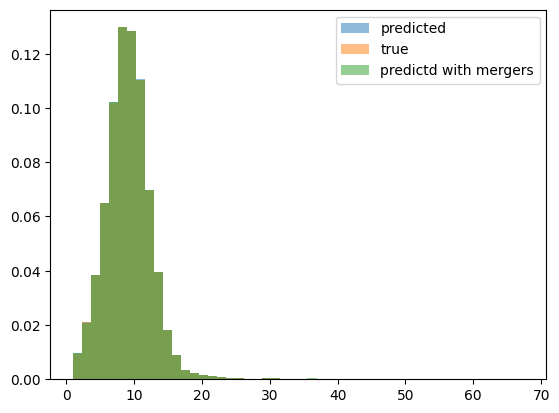

In [18]:
y_pred1 = mc.predict(ma)[:, 0]
y_pred2 = mc_merger2.predict(np.concatenate([x1, x3], axis=1))[:, 0]
_, bins, _ = plt.hist(y_pred1, bins=50, density=True, alpha=0.5, label='predicted')
plt.hist(cat['cvir'], bins=bins, density=True, alpha=0.5, label='true')
plt.hist(y_pred2, bins=bins, density=True, alpha=0.5, label='predictd with mergers')
plt.legend();

# Step by step, where does the distribution break? 

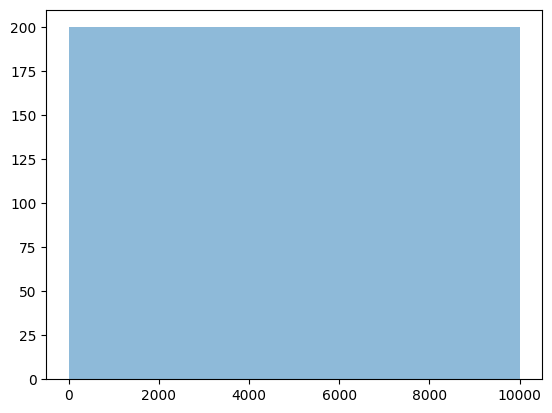

In [39]:
from scipy.stats import rankdata

x = np.concatenate([x1, x3], axis=1)

xr = rankdata(x, axis=0, method="ordinal")

plt.hist(xr[:, 170], bins=50, alpha=0.5); # uniform ranks

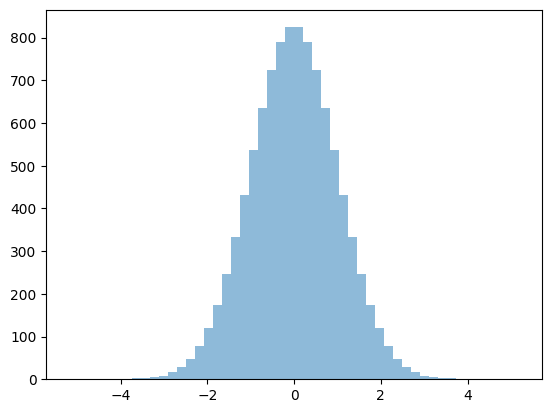

In [32]:
xr_trans = mc_merger2.qt_xr.transform(xr)
plt.hist(xr_trans[:, 170], bins=50, alpha=0.5); # all gaussian

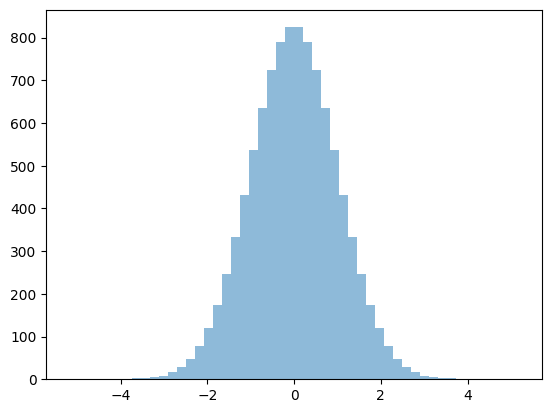

In [37]:
yr_train_trans = mc_merger2._predict(xr_trans)
y_gauss = mc_merger2.qt_pred.transform(yr_train_trans)
plt.hist(y_gauss[:, 2], bins=50, alpha=0.5); # all gaussian

In [41]:
# follow predicion procedure and figure out where it breaks 
xr = np.zeros_like(x) * np.nan
for jj in range(x.shape[1]):
    x_jj = x[:, jj]
    x_train_jj = np.sort(x[:, jj])
    xr_jj = np.searchsorted(x_train_jj, x_jj) + 1  # indices to ranks
    xr_jj = np.minimum(xr_jj, len(x_train_jj))  # clip to max ranks
    xr_jj = np.maximum(xr_jj, 1)  # clip to min ranks (1-indexed)
    xr[:, jj] = xr_jj
assert np.sum(np.isnan(xr)) == 0

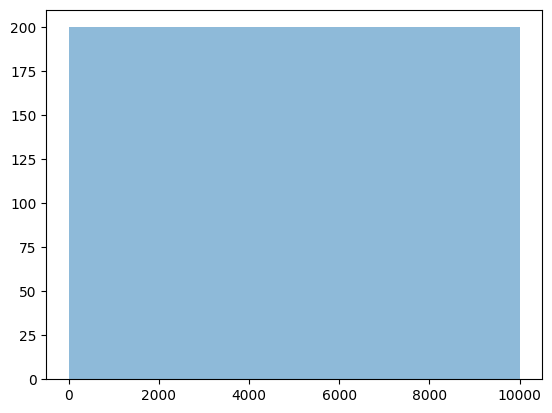

In [80]:
from scipy.stats import rankdata
plt.hist(rankdata(xr[:, 180], method='ordinal'), bins=50, alpha=0.5); # uniform ranks

In [89]:
xr[:, 180][5], rankdata(xr[:, 180], method='ordinal')[5]

(7732.0, 7732)

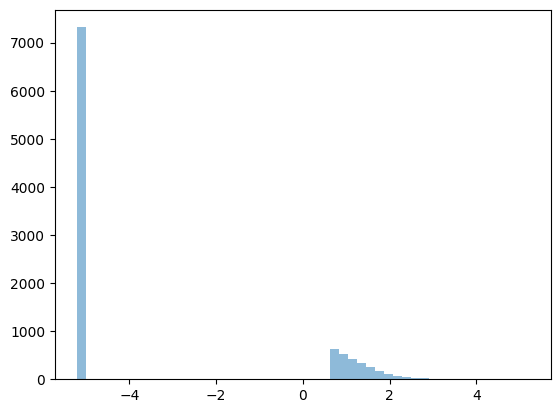

In [71]:
xr_test_trans = mc_merger2.qt_xr.transform(xr)
plt.hist(xr_test_trans[:, -3], bins=50, alpha=0.5);

In [72]:
xr_test_trans[:, -3]

array([-5.19933758,  2.22617293, -5.19933758, ..., -5.19933758,
       -5.19933758, -5.19933758])

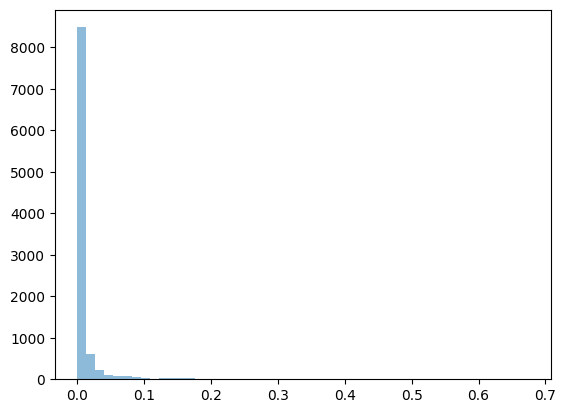

In [57]:
plt.hist(x[:, -2], bins=50, alpha=0.5);

In [69]:
np.sum(x[:, -4] > 0 )

2966

In [65]:
np.median(x[:, -4])

0.0

(array([9.576e+03, 1.930e+02, 9.100e+01, 5.200e+01, 5.500e+01, 3.000e+01,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.10014154, 0.20028309, 0.30042463, 0.40056618,
        0.50070772, 0.60084927, 0.70099081, 0.80113236, 0.9012739 ,
        1.00141545]),
 <BarContainer object of 10 artists>)

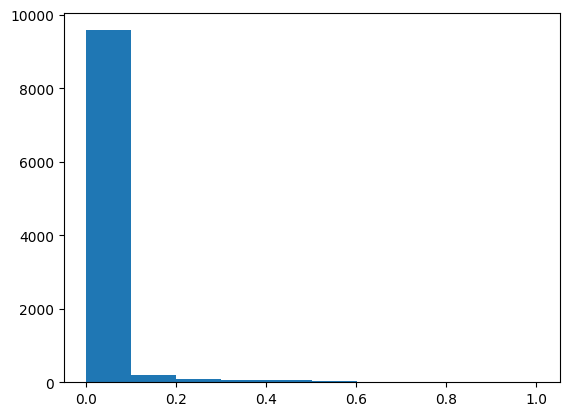

In [66]:
plt.hist(x[:, -4])